<img src="../assets/logo.png" width="50" align="left"> 

# Range

***

#### Prerequesites
- Sampling Data

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Intro - A Realistic Example

<img src="../assets/radar_blip.jpg" width="400">

In the movies, radars are commonly used for military applications like detecting an approaching object. The officer watches as a small blip on the screen comes closer and a decision needs to be made. Is it a friend or a foe? What is really happening is the utilization of a radar for ranging, or detecting how far an object is relative to the radar. Range is the first key piece of information that defines what a radar provides. However, there are manys steps that need to be taken to detect this "object" in the radars FOV. Here, we will only demonstrate how we can use a radar to obtain a distance of "something", which ironically may be nothing at all.

## What the Radar Sees

In our example, we want to know how far the object is from the radar. Let's say our radar sends out a single chirp which eventually (but quickly) bounces off the plane. We then sample the backscatter of this single chirp as our ADC samples. All the information we need to find the range of this object is encoded in these data samples. 

## Discovering Meaning in the ADC Samples

Since each of the samples are taken at equally spaced time intervals, we have a time log of what happened during the chirp. Every sample is a complex number, meaning we have captured some magnitude of power as well as the phase of the wave at that time. So, our object will theoretically appear as an increase in power in our samples. On the other hand, we can use the distinct phases of each sample to obtain distance.

- Power - $P = \sqrt{I^2+Q^2}$
- Phase - $\angle = \arctan{(\frac{I}{Q})}$

($I$=Imaginary Component $Q$=Real Component)

# Processing Range Information

***

## Step 1 - Range FFT

The first step to obtaining range is by performing an FFT across our ADC samples for a single chirp. This unfortunately does not leave you with a single range. Instead, we obtain multiple "range bins". These are exactly what they sound like, bins that store the information for various ranges. 

The way of obtaining range bins in code is straightforward, we literally just need to take an FFT. We can use a library like numpy to quickly accomplish this task. The data I have provided are samples from a single chirp.

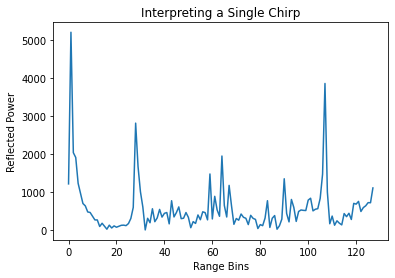

In [2]:
# Read in chirp data
adc_samples = np.loadtxt('../assets/chirp.txt', dtype=np.complex_)

# Manually cast to signed ints
adc_samples.real = adc_samples.real.astype(np.int16)
adc_samples.imag = adc_samples.imag.astype(np.int16)

# Take a FFT across ADC samples
range_bins = np.fft.fft(adc_samples)

# Plot the magnitudes of the range bins
plt.plot(np.abs(range_bins))
plt.xlabel('Range Bins')
plt.ylabel('Reflected Power')
plt.title('Interpreting a Single Chirp')
plt.show()

In [10]:
range_bins

array([ 1.21200000e+03-8.70000000e+01j,  2.86384776e+03-4.34151135e+03j,
       -1.99360988e+03-4.12986333e+02j, -1.89595394e+03-2.19798011e+02j,
       -1.23050921e+03+1.38488979e+00j, -9.68389546e+02+6.08617010e+01j,
       -6.88662657e+02+1.22722146e+02j, -6.21004426e+02+1.41287970e+02j,
       -4.60352230e+02+1.26336939e+02j, -4.38012798e+02+1.53745770e+02j,
       -3.03753071e+02+2.00252384e+02j, -2.43695425e+02+1.11350269e+02j,
       -2.48172946e+02+9.97796337e+01j, -7.39402331e+01+5.92481466e+01j,
       -1.72562931e+02+5.26797404e+01j, -9.47054383e+01+4.15303979e+01j,
        1.24891681e-01-2.42132034e+01j, -1.14410324e+02+6.22120301e+01j,
       -3.70188724e+01-4.29834380e+01j, -1.24575763e+01-1.10113398e+02j,
       -6.33895895e+01-4.25986896e+01j,  8.43508475e+01-5.77100023e+01j,
        8.77023542e+01-9.10720300e+01j, -8.06474680e+01-1.02741603e+02j,
       -1.00623260e+02+6.19261846e+01j, -1.22176977e+02-1.21740056e+02j,
        2.97915835e+02+7.52307982e+01j, -3.43846565

## Step 2 - Unit Conversion
Great! We have successfully interpreted the data received by the radar. We can clearly see peaks and valleys representing possible objects that our radar may see. This is an important step in using our radar data. We have taken many complex samples that are nonsense to us and used our knowledge to interpret a form of measurment that we can understand. There is already so much we can do with this information.

But...there's still a problem you may have noticed, what are the units? My high school physics teacher would say something along the lines of, "are there 128 cows?". Well, I didn't lie to you when I said the units are range bins, the bins grouping objects that are within close proximity. Furthermore, the objects at some range bin index are indeed farther than the objects at the previous index and closer than the objects in the next index. That's probably what you didn't want to hear however. You probably wanted to know in terms of some unambiguous unit, say meters from the metric system. To find the units in meters, let's first start off with the following equations...

- $f = \frac{S2 d}{c}$ - The *IF signal* frequency produced by a single object at distance $d$ (where the object appears in the frequency spectrum after the range FFT) 
    - $f$ - Frequency
    - $S$ - Frequency slope of the signal emitted by the chirp
    - $d$ - Distance relative to the radar
    - $c$ - Speed of light <br> 
- $\Delta f > \frac{1}{T}$ - The minimum separation needed in the frequency spectrum to be resolved by the radar <br>
    - $T$ - Sampling period

Looking at the first equation and we can see there is a direct relationship between $f$ and $d$...

- $f = \frac{S2 d}{c} \Rightarrow \Delta f = \frac{S2 \Delta d}{c}$

So now we have two separate equations that define $\Delta f$. Substitution can be now used.

- $\frac{S2 \Delta d}{c} = \Delta f \gt \frac{1}{T}$
- $\frac{S2 \Delta d}{c} \gt \frac{1}{T}$

Finally, we can solve for $\Delta d$, or the range resolution we can achieve.

- $\Delta d \gt \frac{c}{2} \cdot \frac{1}{ST}$

Since we know $S$ is in some unit of frequency over time, we can simplify $ST$ to just $B$, or the bandwidth of chirp.

- $\Delta d > \frac{c}{2B}$

In other words, the range resolution is only dependent on how large a bandwidth the chirp has. Let's see what information we have to use to try and find this range resolution.

In [13]:
# Data sampling configuration
c = 3e8 # Speed of light (m/s)
sample_rate = 2500 # Rate at which the radar samples from ADC (ksps - kilosamples per second)
freq_slope = 60 # Frequency slope of the chirp (MHz/us)
adc_samples = 128 # Number of samples from a single chirp

Not exactly what we wanted, but the only thing we're missing is our bandwidth $B$. We can still use these parameters to find bandwidth since it is just the span of frequency of the chirp. So, we just need to calculate how much of a frequency span the chirp takes. Ignoring converting units for now, this should be our equation:

- $B = S \cdot \frac{N}{F_s}$
    - $S$ - Frequency slope (frequency/time)
    - $N$ - Number of ADC samples (samples)
    - $F_s$ - Frequency at which we sample ADC samples (samples / time)

In [17]:
np.arange(adc_samples)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

Range Resolution: 0.048828125 [meters]


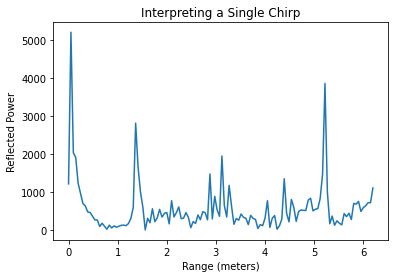

In [14]:
# Calculating bandwidth of the chirp, accounting for unit conversion
chirp_bandwidth = (freq_slope * 1e12 * adc_samples) / (sample_rate * 1e3)

# Using our derived equation for range resolution
range_res = c / (2 * chirp_bandwidth)
print(f'Range Resolution: {range_res} [meters]')

# Apply the range resolution factor to the range indices
ranges = np.arange(adc_samples) * range_res
powers = np.abs(range_bins)

# Now we can plot again with an x-axis that makes sense
plt.plot(ranges, powers)
plt.xlabel('Range (meters)')
plt.ylabel('Reflected Power')
plt.title('Interpreting a Single Chirp')
plt.show()

It should be clear at this point that we have a large amount of control over the range resolution. Just with a few tunable parameters we can make our radar have the resolution of a few centimeters or a few meters. On the other hand, we can make our radar have the range a few meters or hundreds of meters.

# Extras

***

## Range Benefits from mmWave Radars

Radars can detect objects kilometers away, so why not just use them all the time? In short, they were designed just for that and that isn't always what you want. Futhermore, since the wavelengths of the signals are much larger, there is a much more coarse resolution of the range bins. With mmWave radars, we now have the capability of emitting relatively tiny waves. This gives us the opportunity to range at shorter distances with much greater resolution. 

## Recap

In this section, we learned about how a __radar encodes__ range data within its __ADC samples__. There is a straightforward process to extracting this information that can be easily done in code. In code, we first converted this data into units called __range bins__ by performing an __FFT across multiple ADC samples__. These are the discrete relative distances of objects in the radar's view. Then we found the __range resolution__ of each of these range bins, or the range of distance each bin accounts for. However, in order to find calculate the range resolution of the data we needed to have prior knowledge of the configuration of the __chirp__ sent from the radar and the sampling configuration. After we found this, we used it to convert the range bins to a unit that we are all familiar with.

## Looking Forward

Range is a good start, but to more clearly understand why radar is widely used in applications like autonomous vehicles, there are a few more basics we would recommend learning about. These include doppler and angle of arrival (AOA), which are within this same basics section.

Did this notebook seem like it skipped over things? Well, that's because it did. For example, we never actually __detected__ that object in our example, we just made a plot that showed a bunch of peaks within the range bins. If you're impatient, you can look into our notebook about __CFAR__ and see why there is still more work to do. Also, you may have noticed our plots have a large power peak at range bin zero which is zero meters away. There wasn't anything at zero meters (aside from the radar), this is actually a type of interference from the radar itself. You may want to look into the notebook about __Compensation__ to find out how to solve this problem. There is still much more to learn even about range, keep reading!

***

#### Contributors
- Dash Kosaka

#### Questions, Issues, etc.?
Contact by...
- email - presenseradar@gmail.com
- github - https://github.com/presenseradar/openradar